### 导入相关包

In [1]:
from utils.misc import *
from train.train import Train,Test
from datasets.data_utils import load_dataset
from model.Creat_model import creat_model
from utils.preprocess import *
from utils.utils import *

2025-04-01 14:47:48.307608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-01 14:47:48.613789: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 14:47:49.478945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:
2025-04-01 14:47:49.479058: W tensorflow/compiler/xla/stream_executor/p

In [2]:
from torch.backends import cudnn
def fix_seed(seed):
    #seed = 2023
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'   

In [3]:
import networkx
import torch
import scipy.sparse as sp
import numpy as np
import os
import random
from munkres import Munkres
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.decomposition import PCA
from torch.utils.data import Dataset
import argparse
import yaml
from torch_geometric.utils.convert import to_networkx
import pynvml

def build_args():
    
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--dataset', type=str, default="acm")
    parser.add_argument('--seed', type=int, default=20)
    parser.add_argument('--cuda', type=bool, default=True)
    parser.add_argument('--n_input', type=int, default=None)
    parser.add_argument('--n_z', type=int, default=None)
    parser.add_argument('--freedom_degree', type=float, default=1.0)
    parser.add_argument('--epoch', type=int, default=None)
    parser.add_argument('--shuffle', type=bool, default=True)
    parser.add_argument('--sigma', type=float, default=None)
    parser.add_argument('--loss_n', type=float, default=None)
    parser.add_argument('--loss_w', type=float, default=None)
    parser.add_argument('--loss_s', type=float, default=None)
    parser.add_argument('--loss_a', type=float, default=None)
    parser.add_argument('--lr', type=float, default=1e-4)
    parser.add_argument('--acc', type=float, default=-1)
    parser.add_argument('--f1', type=float, default=-1)
    args = parser.parse_args([])
    return args

In [4]:
def pca(adata, use_reps=None, n_comps=10):
    
    """Dimension reduction with PCA algorithm"""
    
    from sklearn.decomposition import PCA
    from scipy.sparse.csc import csc_matrix
    from scipy.sparse.csr import csr_matrix
    pca = PCA(n_components=n_comps)
    if use_reps is not None:
       feat_pca = pca.fit_transform(adata.obsm[use_reps])
    else: 
       if isinstance(adata.X, csc_matrix) or isinstance(adata.X, csr_matrix):
          feat_pca = pca.fit_transform(adata.X.toarray()) 
       else:   
          feat_pca = pca.fit_transform(adata.X)
    
    return feat_pca

def clr_normalize_each_cell(adata, inplace=True):
    
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()
    
    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else np.array(adata.X))
    )
    return adata     

In [5]:
args = build_args()
args = load_configs(args, "config/configs.yml")
# set_random_seed(2024)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load configs


### 导入模拟数据

In [6]:

import scanpy as sc
adata_omics1 = sc.read_h5ad( '/home/hfzhang/data/空间转录组/moni/adata_omics1.h5ad')
adata_omics2 = sc.read_h5ad('/home/hfzhang/data/空间转录组/moni/adata_omics2.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()
adata_omics1 = adata_omics1[adata_omics1.obs['labels'].notna()]  
adata_omics2 = adata_omics2[adata_omics2.obs['labels'].notna()] 

In [7]:

# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
# sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.scale(adata_omics1)

# adata_omics1 =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1, n_comps=adata_omics2.n_vars-1)
# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/tmp/ipykernel_15427/529664883.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  from scipy.sparse.csc import csc_matrix
/tmp/ipykernel_15427/529664883.py:7: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix
/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/tmp/ipykernel_15427/529664883.py:6: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace i

In [8]:
def create_adj(adata):
    cell_position_omics1 = adata.obsm['spatial']
    adj_omics1 = construct_graph_by_coordinate(cell_position_omics1, n_neighbors=3)
    adata.uns['adj_spatial'] = adj_omics1
    adj_spatial_omics1 = adata.uns['adj_spatial']
    adj_spatial_omics1 = transform_adjacent_matrix(adj_spatial_omics1)
    adj_spatial_omics1 = adj_spatial_omics1.toarray()
    adj_spatial_omics1 = adj_spatial_omics1 + adj_spatial_omics1.T
    adj_spatial_omics1 = np.where(adj_spatial_omics1>1, 1, adj_spatial_omics1)
    adj = preprocess_graph(adj_spatial_omics1)
    return adj

In [9]:
label=adata_omics2.obs['labels'].values
classes, label = np.unique(label, return_inverse=True)
classes = classes.tolist()

In [10]:
args.n_input=adata_omics2.n_vars-1
args.n_input1=adata_omics2.n_vars-1
args.n_clusters=len(classes)
args.n_clusters
random_seek=2020
args.random_seed=random_seek
fix_seed(random_seek)

In [12]:
args.loss_n=0.01
args.lr=0.01
args.sigma=0.5
device='cuda:0'
args.tool='kmeans'

In [20]:
args.n_clusters1=len(set(label))
args.n_clusters2=len(set(label))
adj_train=create_adj(adata_omics1)
adj_train = adj_train.to(device)
features_omics1 = torch.FloatTensor(adata_omics1.obsm['feat'].copy()).to(device)
features_omics2 = torch.FloatTensor(adata_omics2.obsm['feat'].copy()).to(device)
model = creat_model('spamgcn', args).to(device)
model=Train(80, model, adata_omics1,features_omics1,features_omics2, adj_train, label, device, args)
nmi, ari, ami, homogeneity, completeness, v_measure=Test(model,adata_omics1,features_omics1,features_omics2,adj_train,label,device,args,'kmeans')
print('nmi {:.4f}'.format(nmi),  
          ', ari {:.4f}'.format(ari),  
          ', ami {:.4f}'.format(ami),  
          ', homogeneity {:.4f}'.format(homogeneity),  
          ', completeness {:.4f}'.format(completeness),  
          ', v_measure {:.4f}'.format(v_measure)) 


Epoch_  0 , nmi 1.0000 , ari 1.0000 , ami 1.0000 , homogeneity 1.0000 , completeness 1.0000 , v_measure 1.0000
聚类方法为kmeans
test
name: acm
NMI : 1.0000
ARI : 1.0000
AMI  : 1.0000
, nmi 1.0000 , ari 1.0000 , ami 1.0000 , homogeneity 1.0000 , completeness 1.0000 , v_measure 1.0000


### 可视化结果

/home/hfzhang/software/anaconda3/envs/GraphST/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


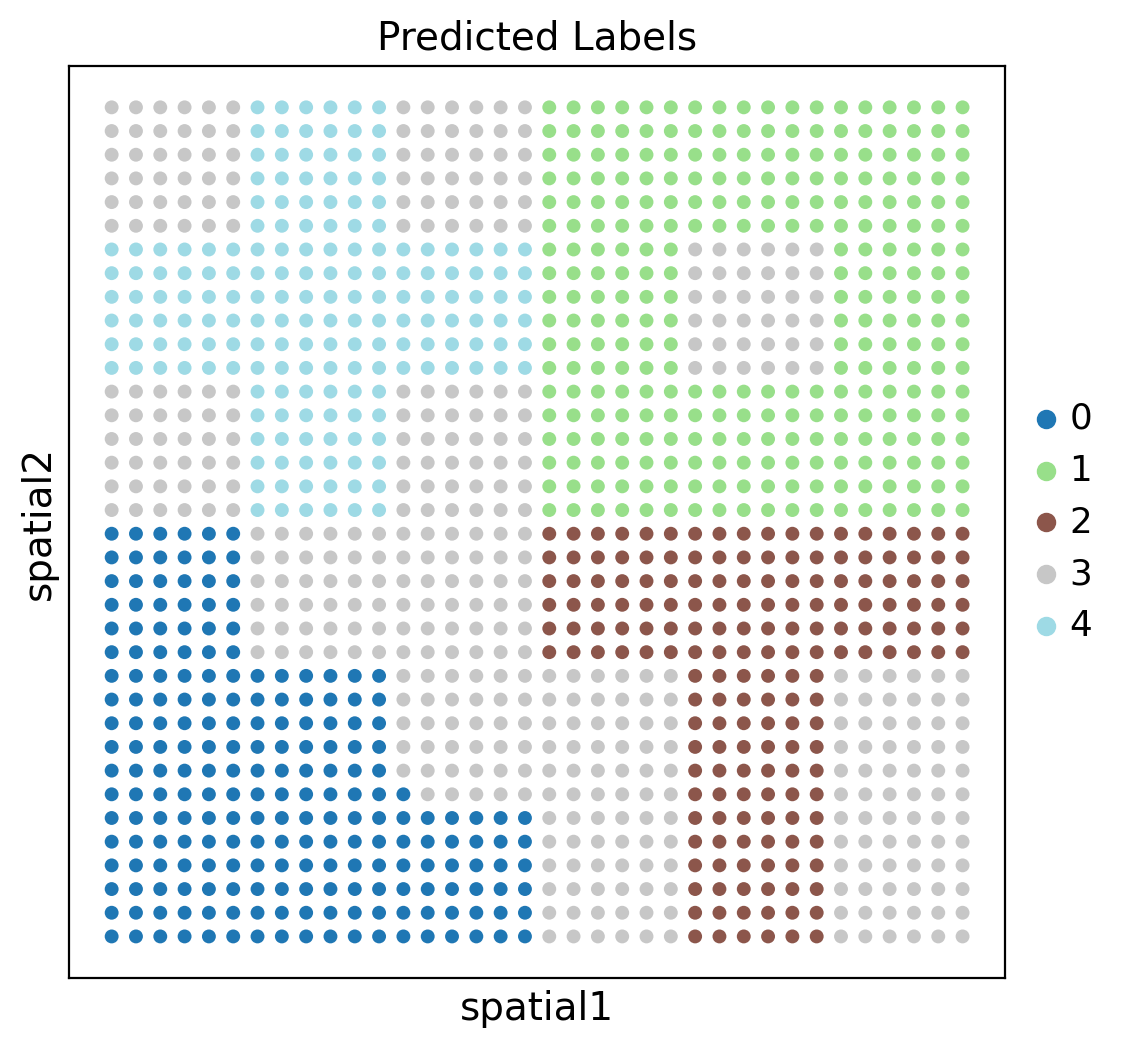

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt

# 2. 设置绘图参数
sc.set_figure_params(figsize=(6, 6), dpi=100)
sc.pl.embedding(
    adata_omics1,
    basis='spatial',  # 使用空间坐标
    color='pred',  # 使用 obs 中的 pred 列作为颜色
    title='Predicted Labels',
    palette='tab20',  # 使用高对比度的颜色映射
    size=100,  # 调整点的大小，值越大，点越大
    show=False,  # 不立即显示，方便保存或调整
)

# 5. 显示图像
plt.show()